In [125]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
from sim_engine import F_lam_per_M
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared
from C_sim_test import Gen_sim, F_lam_per_M

import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [3]:
sim1 = Gen_spec('GND', 21156, 1.25257,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = True,
            phot_errterm = 0.0, decontam = False) 

sim2 = Gen_spec('GND', 21156, 1.25257,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = True,
            phot_errterm = 0.0, decontam = False) 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [4]:
specz = 1.25

In [93]:
u = 0.0
lbt = []
for i in range(10):
    u+=0.1 * i
    lbt.append(np.round(u,1))
print(lbt)
print(np.round(u + 0.1 * (i+1),1))

[0.0, 0.1, 0.3, 0.6, 1.0, 1.5, 2.1, 2.8, 3.6, 4.5]
5.5


In [97]:
def Time_bins(agelim, bins):
    u = 0.0
    lbt = []
    for i in range(bins):
        u+=0.1 * i
        lbt.append(np.round(u,1))
    
    return np.array(agelim  - lbt / np.round(u + 0.1 * (i+1),1) * agelim)[::-1]

LBT = Time_bins(Oldest_galaxy(1.25),10)
print(LBT)

[0.90396774 1.7175387  2.44071289 3.0734903  3.61587094 4.06785481
 4.4294419  4.70063222 4.88142577 4.97182254]


In [15]:
LBT

array([1.65727418, 2.98309353, 3.97745804, 4.64036771, 4.97182254])

In [135]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2

sp.set_tabular_sfh(LBT,np.array([70, 80, 50, 10, 1, 0.1, 0.001, 0.02, 0.2, 0.01]),
                   Z = np.array([0.2, 0.8, 1.0, 1.0, 0.8, 1.1, 0.7, 0.8, 0.8, 0.8])*0.019)

wave1, flux1 = sp.get_spectrum(tage = 3.5, peraa = True)

mass_perc1 = sp.stellar_mass


In [129]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.params['tau'] =0.3
sp.params['logzsol'] = np.log10(0.8)

wave2, flux2 = sp.get_spectrum(tage = 3.5, peraa = True)

mass_perc2 = sp.stellar_mass


In [45]:
def get_50(LBT, md,age):
    hrtime = np.round(np.arange(0,LBT[-1],0.001),2)
    dt = 0.001   
    mass = np.zeros(len(hrtime))
    mbu = 0
    u = 0
    for i in range(len(hrtime)):
        if hrtime[i] > LBT[u]:
            u+=1
        mass[i] = mbu
        mbu += md[u] * dt

    mass = mass[hrtime < age]
    hrtime = hrtime[hrtime < age]
    print(mass[-1])

    return interp1d(mass,hrtime)(0.5), hrtime, mass

In [112]:
get_50(LBT, tabsfh, Oldest_galaxy(specz) -0.1)

171.60456100000752


(array(0.01),
 array([0.  , 0.  , 0.  , ..., 4.87, 4.87, 4.87]),
 array([0.00000000e+00, 7.00000000e-02, 1.40000000e-01, ...,
        1.71604161e+02, 1.71604361e+02, 1.71604561e+02]))

In [100]:
sfrbins = []
isfh = interp1d(t ,sfh)

for ii in range(len(LBT)):
    
    if ii == 0:
        A = 0
        B = LBT[0]
    
    else:
        A = LBT[ii-1]
        B = LBT[ii]
    
    
    sfrbins.append(np.trapz(isfh(np.arange(A, B, 0.001)), np.arange(A, B, 0.001) ))

In [101]:
sfrbins,tabsfh

([0.7995740851692483,
  0.17761268327666557,
  0.0195734404284452,
  0.002313257931671212,
  0.00032882849930403153,
  5.8203877961037027e-05,
  1.2910180650250306e-05,
  3.549463845024002e-06,
  1.147116941288952e-06,
  3.712041703971919e-07],
 array([5.93324271e-01, 8.89986407e-03, 5.93324271e-03, 2.96662136e-04,
        5.93324271e-04]))

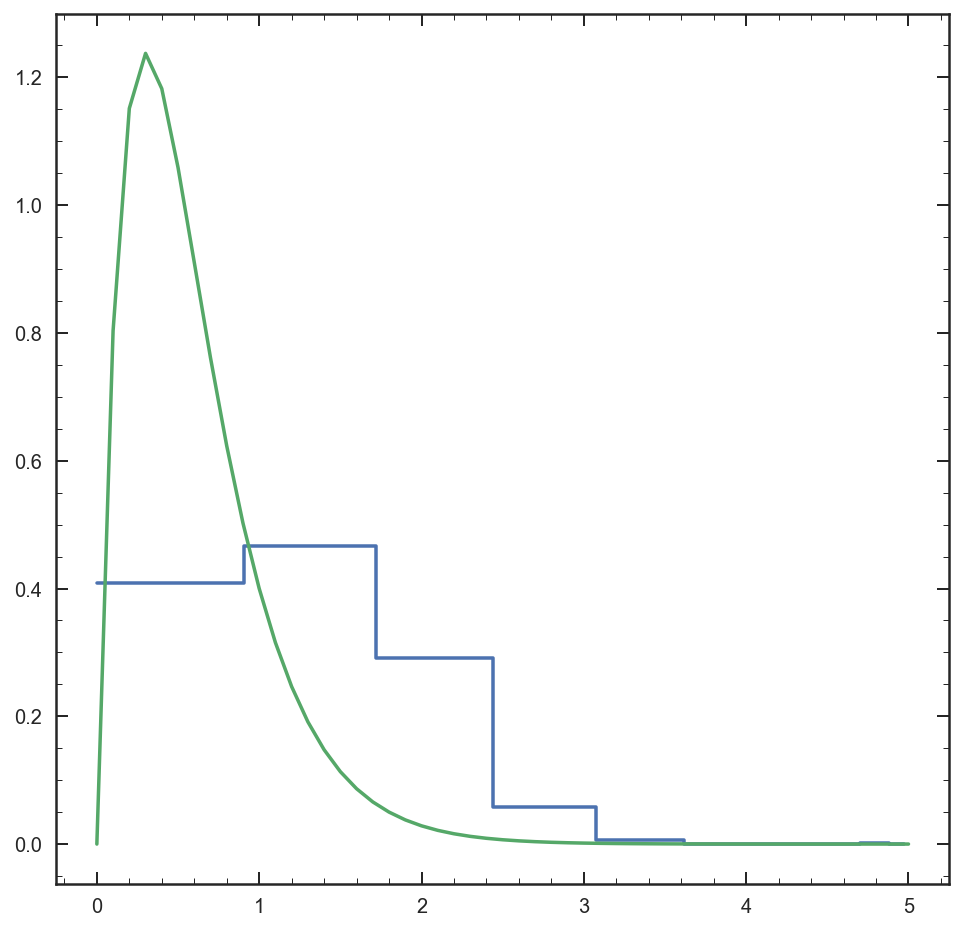

In [114]:
t= np.arange(0,Oldest_galaxy(1.25)+.1,.1)

sfh = t * np.exp(-t / 0.3)
tabsfh = np.array([70, 80, 50, 10, 1, 0.1, 0.001, 0.02, 0.2, 0.01])

sfh /= np.trapz(sfh,t)
tabsfh /= 171.60456

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(tabsfh[0], tabsfh))

plt.plot(t,sfh)
# plt.plot(LBT, np.array(sfrbins) ,'*', ms=40)


In [118]:
conv = cosmo.luminosity_distance(specz).value *4 * np.pi
mass = 10**11 * 1E9 * conv


In [130]:
mass_perc2

0.6370598238085273

In [142]:
flam1 = F_lam_per_M(flux1,wave1 * (1+1.25),1.25,0,mass_perc1)
flam2 = F_lam_per_M(flux2,wave2 * (1+1.25),1.25,0,mass_perc2)

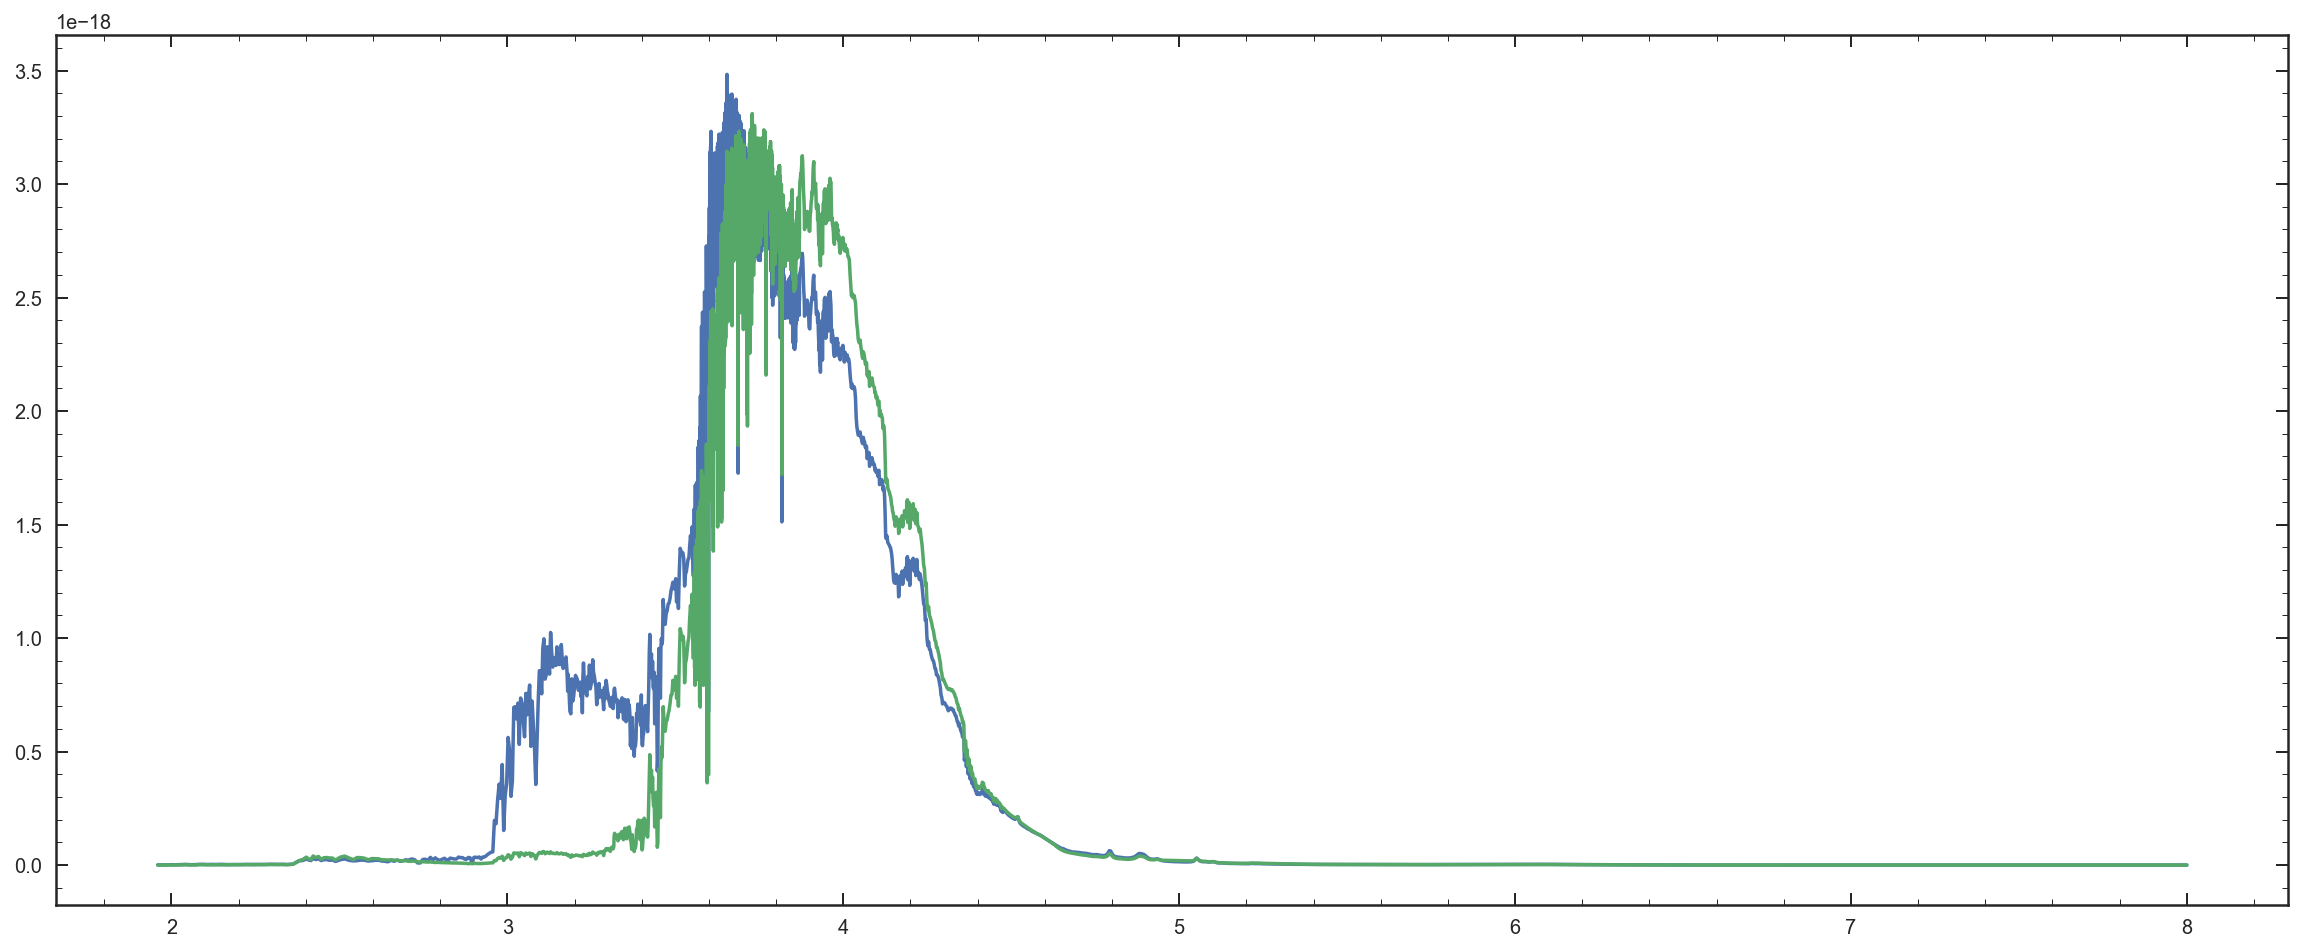

In [143]:
plt.figure(figsize=[20,8])

plt.plot(np.log10(wave1), flam1 * 10**11)
plt.plot(np.log10(wave2), flam2 * 10**11.3)

# plt.xlim(np.log10(3000),np.log10(8000))

## Define Priors

In [141]:
agelim = Oldest_galaxy(specz)

def delay_prior(u):
    m = (0.03 * u[0] + 0.001) / 0.019
    a = (agelim - 0.01)* u[1] + 0.01
    t = (1.5 - 0.001)*u[2] + 0.001  
    z = specz + 0.002*(2*u[3] - 1)
    d = 1*u[4]
    lm = 11.0 + 1.25*(2*u[5] - 1)

    return [m, a, t, z, d, lm]

def tab_prior(u):
    m1 = (0.03 * u[0] + 0.001) / 0.019
    m2 = (0.03 * u[1] + 0.001) / 0.019
    m3 = (0.03 * u[2] + 0.001) / 0.019
    m4 = (0.03 * u[3] + 0.001) / 0.019
    m5 = (0.03 * u[4] + 0.001) / 0.019
    m6 = (0.03 * u[5] + 0.001) / 0.019
    m7 = (0.03 * u[6] + 0.001) / 0.019
    m8 = (0.03 * u[7] + 0.001) / 0.019
    m9 = (0.03 * u[8] + 0.001) / 0.019
    m10 = (0.03 * u[9] + 0.001) / 0.019
    
    a = (agelim - 0.01)* u[10] + 0.01
    
    t1 = u[11]
    t2 = u[12]
    t3 = u[13]
    t4 = u[14]
    t5 = u[15]  
    t6 = u[16]
    t7 = u[17]
    t8 = u[18]
    t9 = u[19]
    t10 = u[20] 
    
    d = 1*u[21]
    
    lm = 11.0 + 1.25*(2*u[22] - 1)
    
    return [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, a, t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, d, lm]

## Define Likelihoods

In [ ]:
def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)

def Full_scale(spec, Pmfl):
    return Scale_model(spec.Pflx, spec.Perr, Pmfl)

def Gather_grism_data(spec):
    wvs = []
    flxs = []
    errs = []
    beams = []
    trans = []
    
    if spec.g102:
        wvs.append(spec.Bwv)
        flxs.append(spec.Bfl)
        errs.append(spec.Ber)
        beams.append(spec.Bbeam)
        trans.append(spec.Btrans)
    
    if spec.g141:
        wvs.append(spec.Rwv)
        flxs.append(spec.Rfl)
        errs.append(spec.Rer)
        beams.append(spec.Rbeam)
        trans.append(spec.Rtrans)

    return np.array([wvs, flxs, errs, beams, trans])

def Full_forward_model(spec, wave, flux, specz):
    Gmfl = []
    
    for i in range(len(wvs)):
        Gmfl.append(forward_model_all_beams(beams[i], trans[i], wvs[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl


def Full_fit(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        Gchi = Gchi + np.sum(((((flxs[i] / scale) - Gmfl[i]) / (errs[i] / scale))**2))
    
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))
    
    return Gchi, Pchi

def delay_L(X):
    m, a, t, z, d, lm = X
    
    sp.params['logzsol'] = np.log10( m )
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['tau'] = t

    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
    flam =  F_lam_per_M(flux, wave * (1+z), z, 0, sp.stellar_mass)
    
    Gmfl, Pmfl = Full_forward_model(Gs, wave, flam * 10**lm, z)
    
#     PC= Full_scale(Gs, Pmfl)

    Gchi, Pchi = Full_fit(Gs, Gmfl, Pmfl)
                  
    return -0.5 * (Gchi + Pchi)

def tab_L(X):
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, a, t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, d, lm = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    
    sp.set_tabular_sfh(LBT,np.array([t1, t2, t3, t4, t5, t6, t7, t8, t9, t10]),
                      Z = np.array([m1, m2, m3, m4, m5, m6, m7, m8, m9, m10]) * 0.019)
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
    flam =  F_lam_per_M(flux, wave * (1+z), z, 0, sp.stellar_mass)
    
    Gmfl, Pmfl = Full_forward_model(Gs, wave, flam * 10**lm, z)
    
#     PC= Full_scale(Gs, Pmfl)

    Gchi, Pchi = Full_fit(Gs, Gmfl, Pmfl)
                  
    return -0.5 * (Gchi + Pchi)



## Setup

In [ ]:
def Time_bins(agelim, bins):
    u = 0.0
    lbt = []
    for i in range(bins):
        u+=0.1 * i
        lbt.append(np.round(u,1))
    
    return np.array(agelim  - lbt / np.round(u + 0.1 * (i+1),1) * agelim)[::-1]

LBT = Time_bins(Oldest_galaxy(1.25),10)